In [22]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# Path to  file
file_path = r"C:\Users\dywin\Documents\Caltech\Data\Force_Data\test1.txt"

# Read the file into a DataFrame
df = pd.read_csv(file_path, header=None, names=["Time_ms", "Force1_N", "Force2_N"])

# Convert milliseconds to seconds in-place
df["Time_ms"] = df["Time_ms"] / 1000.0
df.rename(columns={"Time_ms": "Time_s"}, inplace=True)

# Preview the data
print(df.head())

   Time_s  Force1_N  Force2_N
0    0.00     0.447       0.0
1    0.02     0.916       0.0
2    0.04     1.577       0.0
3    0.06     2.170       0.0
4    0.08     2.758       0.0


In [23]:
df

,Time_s,Force1_N,Force2_N
0,0.000,0.447,0.000
1,0.020,0.916,0.000
2,0.040,1.577,0.000
3,0.060,2.170,0.000
4,0.080,2.758,0.000
...,...,...,...
245,4.909,20.000,18.828
246,4.929,20.000,18.828
247,4.950,20.000,18.828
248,4.970,20.000,18.828


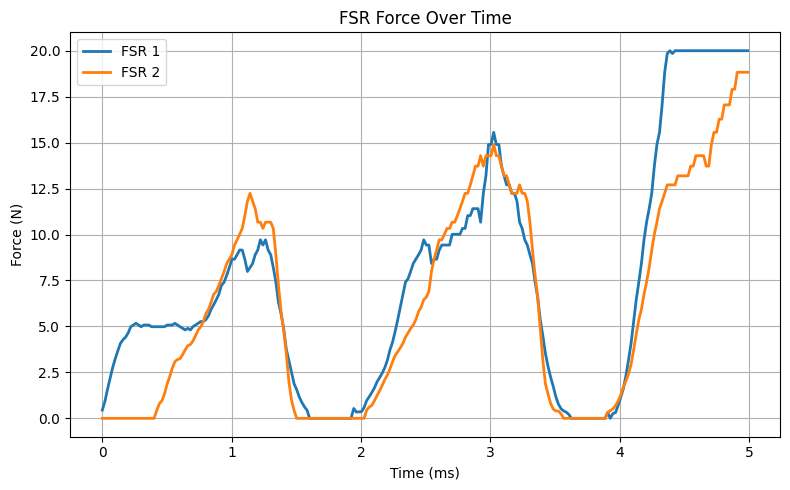

In [30]:
# Plot Force1 and Force2 over Time with legend
plt.figure(figsize=(8, 5))
plt.plot(df["Time_s"], df["Force1_N"], label="FSR 1", linewidth=2)
plt.plot(df["Time_s"], df["Force2_N"], label="FSR 2", linewidth=2)
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
plt.title("FSR Force Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Find local maxima in FSR1 and FSR2 signals with prominence filtering
peaks1, _ = find_peaks(df["Force1_N"], prominence=2, distance=10)
peaks2, _ = find_peaks(df["Force2_N"], prominence=2, distance=10)

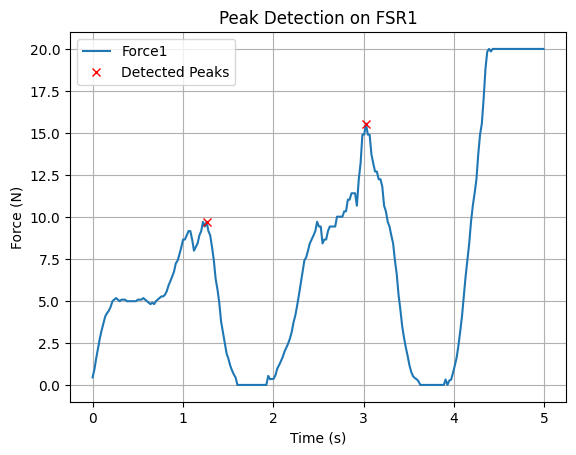

In [33]:
plt.plot(df["Time_s"], df["Force1_N"], label="Force1")
plt.plot(df["Time_s"].iloc[peaks1], df["Force1_N"].iloc[peaks1], 'rx', label="Detected Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.title("Peak Detection on FSR1")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
window = 0.5  # seconds before and after peak
fs = 50  # sampling frequency = 1000 ms / 20 ms = 50 Hz
samples_window = int(window * fs)

segments = []

for peak_idx in peaks1:
    t0 = df.index[peak_idx] - samples_window
    t1 = df.index[peak_idx] + samples_window
    if t0 < 0 or t1 >= len(df): continue
    seg = df.iloc[t0:t1].copy()
    seg["step_id"] = len(segments)
    segments.append(seg)


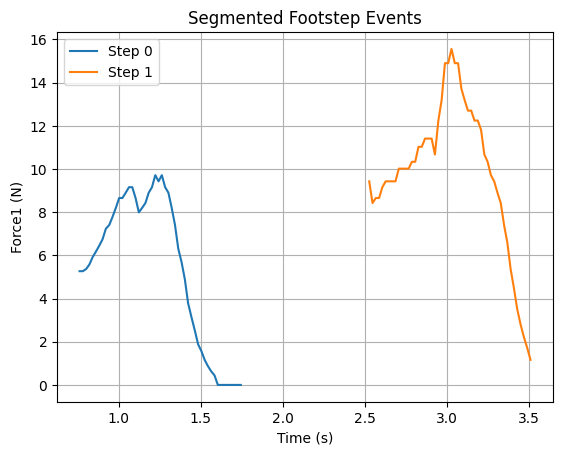

In [35]:
for i, segment in enumerate(segments):
    plt.plot(segment["Time_s"], segment["Force1_N"], label=f"Step {i}")
plt.xlabel("Time (s)")
plt.ylabel("Force1 (N)")
plt.title("Segmented Footstep Events")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
feature_list = []

for seg in segments:
    f1 = seg["Force1_N"].values
    f2 = seg["Force2_N"].values
    combined = f1 + f2
    time = seg["Time_s"].values
    peak_idx = np.argmax(combined)
    peak_time = time[peak_idx]

    combined_max = np.max(combined)
    combined_min = np.min(combined)
    combined_80 = 0.8 * combined_max

    # Time to reach 80% of max
    try:
        t_80 = time[np.where(combined >= combined_80)[0][0]] - time[0]
    except IndexError:
        t_80 = np.nan

    features = {
        "step_id": seg["step_id"].iloc[0],
        "f1_max": np.max(f1),
        "f1_min": np.min(f1),
        "f1_mean": np.mean(f1),
        "f1_std": np.std(f1),
        "f1_skew": skew(f1),
        "f1_kurt": kurtosis(f1),
        
        "f2_max": np.max(f2),
        "f2_min": np.min(f2),
        "f2_mean": np.mean(f2),
        "f2_std": np.std(f2),
        "f2_skew": skew(f2),
        "f2_kurt": kurtosis(f2),
        
        "combined_max": combined_max,
        "combined_min": combined_min,
        "combined_peak_time": peak_time,
        "time_to_80pct_max": t_80,
    }

    feature_list.append(features)

features_df = pd.DataFrame(feature_list)

In [37]:
features_df

,step_id,f1_max,f1_min,f1_mean,f1_std,f1_skew,f1_kurt,f2_max,f2_min,f2_mean,f2_std,f2_skew,f2_kurt,combined_max,combined_min,combined_peak_time,time_to_80pct_max
0,0,9.714,0.000,5.37272,3.471302,-0.444250,-1.349947,12.243,0.000,5.92292,4.377279,-0.247703,-1.476395,20.444,0.000,1.142,0.221
1,1,15.560,1.163,9.83324,3.423554,-0.784136,0.384816,14.900,0.404,10.32522,3.996643,-1.251069,0.589388,30.460,1.567,3.026,0.340


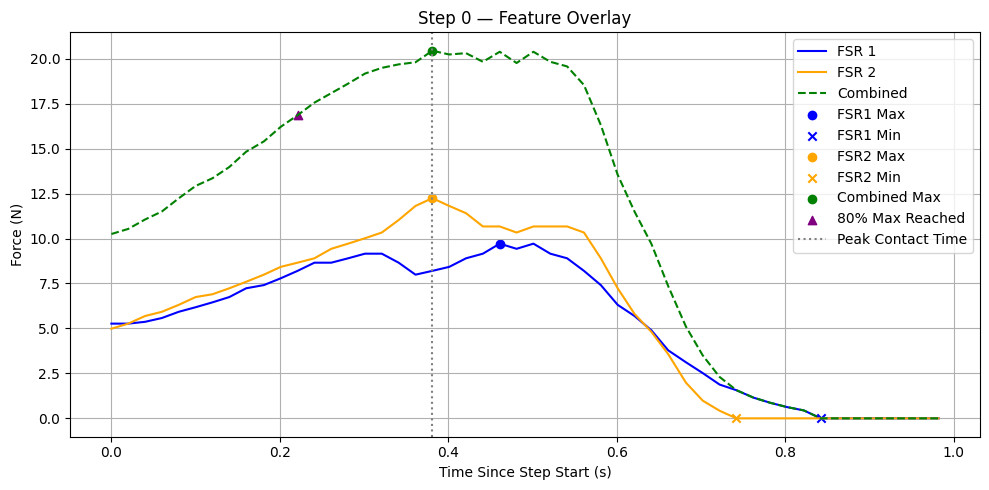

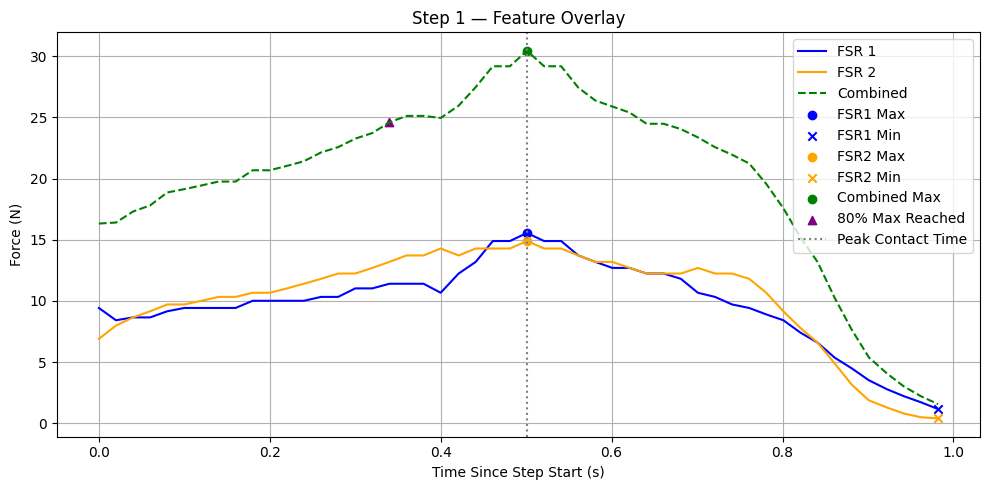

In [38]:
for i, segment in enumerate(segments):
    features = features_df.iloc[i]
    
    # Time normalized to step start
    t = segment["Time_s"].values
    t0 = t[0]
    t_norm = t - t0
    
    f1 = segment["Force1_N"].values
    f2 = segment["Force2_N"].values
    combined = f1 + f2

    # Identify indices for key values
    idx_max_combined = np.argmax(combined)
    val_80pct = 0.8 * combined[idx_max_combined]
    try:
        idx_80pct = np.where(combined >= val_80pct)[0][0]
    except IndexError:
        idx_80pct = None

    plt.figure(figsize=(10, 5))
    
    # Plot all signals
    plt.plot(t_norm, f1, label="FSR 1", color="blue")
    plt.plot(t_norm, f2, label="FSR 2", color="orange")
    plt.plot(t_norm, combined, label="Combined", color="green", linestyle='--')
    
    # Highlight maxima and minima
    plt.scatter(t_norm[np.argmax(f1)], np.max(f1), color='blue', marker='o', label="FSR1 Max")
    plt.scatter(t_norm[np.argmin(f1)], np.min(f1), color='blue', marker='x', label="FSR1 Min")
    plt.scatter(t_norm[np.argmax(f2)], np.max(f2), color='orange', marker='o', label="FSR2 Max")
    plt.scatter(t_norm[np.argmin(f2)], np.min(f2), color='orange', marker='x', label="FSR2 Min")

    # Highlight combined max
    plt.scatter(t_norm[idx_max_combined], combined[idx_max_combined], color='green', marker='o', label="Combined Max")

    # Highlight time to 80% of max
    if idx_80pct is not None:
        plt.scatter(t_norm[idx_80pct], combined[idx_80pct], color='purple', marker='^', label="80% Max Reached")

    # Vertical line at peak contact time (from absolute time)
    peak_contact_time = features["combined_peak_time"]
    t_peak_contact = peak_contact_time - t0
    plt.axvline(x=t_peak_contact, color='gray', linestyle=':', label="Peak Contact Time")

    # Title and labels
    plt.title(f"Step {int(features['step_id'])} — Feature Overlay")
    plt.xlabel("Time Since Step Start (s)")
    plt.ylabel("Force (N)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()